In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

filepath = r"C:\Users\vansh\AI and ML reading material\MakeMore-Implementing NLP models\names.txt"

In [3]:
#read in the dataset
words = open(filepath, 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
print("The total number of words in the dataset are: ",len(words))

The total number of words in the dataset are:  32033


In [10]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [59]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

block_size = 8 #context length: how many characters do we take to predic the next one
def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [60]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->' ,itos[y.item()])

........ ---> e
.......e ---> l
......el ---> i
.....eli ---> a
....elia ---> n
...elian ---> y
..eliany ---> s
.elianys ---> .
........ ---> t
.......t ---> r
......tr ---> o
.....tro ---> y
....troy ---> .
........ ---> m
.......m ---> a
......ma ---> r
.....mar ---> k
....mark ---> u
...marku ---> s
..markus ---> .


### Multi layer Perceptron with Batch-Normalization
TO set the baseline, we will reimplement MLP model here

In [61]:
# ----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
# -----------------------------------------------------------------------------------------------


In [62]:
n_embed = 10 #the dimensionality of the character embedding vectors
n_hidden = 100 #number of hidden neurons in each of the layers
g = torch.Generator().manual_seed(1234567)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].weight *=0.1
    #all other layers: apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True
    

51497


In [63]:
#same optimization as before
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  20000: 3.2916
  10000/  20000: 1.9722


KeyboardInterrupt: 

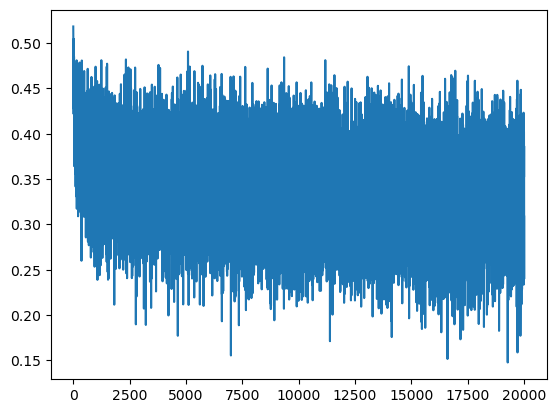

In [ ]:
plt.plot(lossi)

In [ ]:
#put layers into evaluation mode, that is they will not learn from the data
#that is passed during evaluation mode

for layer in layers:
    layer.training = False
    

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.1382997035980225
val 2.180765390396118


In [22]:
#sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward pass
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        #if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
    

pyoneliya.
abdiun.
aase.
sutte.
vict.
haydon.
vyonyni.
zebulangzyan.
abel.
luka.
lajeyyn.
raidyn.
yazder.
latir.
bely.
aleshan.
aus.
adieline.
fraia.
ali.


Simplifying the model futher by making classes of different layers

In [64]:
# ----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]
  
# --------------------------------------------------------------------------------------------------

class Flatten:
  

  def __call__(self, x):
    if x is None:
      raise ValueError("Input x is None, but a tensor is expected.")
    if not hasattr(x, 'view'):
      raise TypeError("Input x does not have the 'view' method. Ensure it is a tensor.")
        
    self.out = x.view(x.shape[0], -1)  # this is according to our convenience
    return self.out
  
  def parameters(self):
    return []
# ---------------------------------------------------------------------------------------------------------

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def paramters(self):
    #get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [65]:
torch.manual_seed(42)

In [66]:
n_embed = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed * block_size, n_hidden, bias=False),
    Linear(n_hidden, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, n_hidden), Tanh(), BatchNorm1d(n_hidden),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 #make last layer less confident

parameters = model.paramters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    

184097


In [67]:
#same optimization as the last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update:simple SGD
    lr = 0.1 if i<15000 else 0.01
    for p in parameters:
        p.data += -lr* p.grad

    #track stats
    if i % 10000 == 0: #print every once in while
        print(f'{i:7d}/{max_steps:7d} : {loss.item(): .4f}')
    lossi.append(loss.log10().item())
    

      0/  20000 :  3.6884
  10000/  20000 :  2.0689


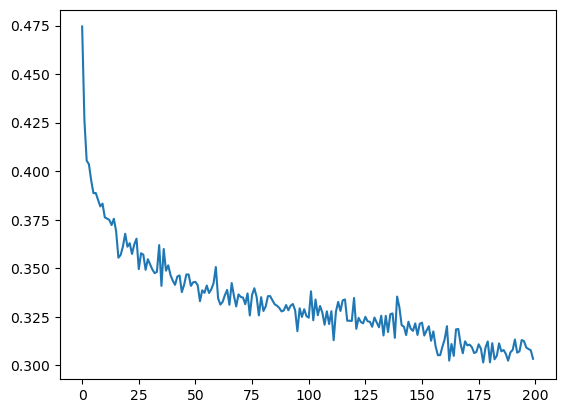

In [68]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [69]:
#put model in evaluation mode
for layer in model.layers:
    layer.training = False
    

In [70]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0006136894226074
val 2.059213161468506


In [56]:
#sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward pass
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        #if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
    

anuek.
smaknmsqynrmevilaleqevylysykcrucalyomtxmjgaecsiqilimhepvviqatsjrqdewilclkaldmivnyneauweeojnsnjftlidajr.
fjeiwjcseihnaskme.
o.
eurawldynleddkanwaifdesviebstumvtoc.
anxqeonnscvznepoynxhhsaoamqmmywsgldpwmnnenbaetqbnyntsyintdr.
ddoxsoypasfctynypcrvik.
lijvqdokptaessunlznyunvhctlhp.
gwoatmysenelmwclfhrpak.
psu.
hkkcllmoq.
.
bxg.
ajiecgirbshzrbolnyihjjesyegvtraeedgetx.
ahocesudykjxxgyxurtqmkrdlcm.
vctdw.
tw.
dpisvawdslkvaiewhavfiexoybxhyzfeegaaixlqetbomseksovmkoorximsuvvuyuaqdmkeu.
trvc.
oimszlacbrggwekytjprqajueemeiclvzhewhnnmzbzwhhwajckhpcwiwngagneyocbhqezqadtcecgeettleyhmsrhxewymetqvslzfybyhxhsghnuoyshmgngydmehhfxkormptbsl.


### Wavenet

instead of processing each character separaterly, we take n number of characters together and process them.

In [125]:
# ----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]
  
# --------------------------------------------------------------------------------------------------

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    if x is None:
      raise ValueError("Input x is None, but a tensor is expected.")
    if not hasattr(x, 'view'):
      raise TypeError("Input x does not have the 'view' method. Ensure it is a tensor.")
        
    B, T, C = x.shape
    x = x.view(B, (T//self.n), (C * self.n))  # this is according to our convenience
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []
# ---------------------------------------------------------------------------------------------------------

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def paramters(self):
    #get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [127]:
n_embed = 10
n_hidden = 68
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2),
    Linear(n_embed * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
])

#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 #make last layer less confident

parameters = model.paramters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    

22397


In [121]:
ix = torch.randint(0, Xtr.shape[0], (4, )) #look at a batch of 4 examples
print(ix)
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

tensor([172537,  55377,  98692, 178227])
torch.Size([4, 4, 20])
torch.Size([4, 2, 400])
torch.Size([4, 1, 400])
torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 18, 15],
        [ 0,  0,  0,  0,  0,  0,  0,  6],
        [ 0,  0,  0,  0,  2, 18, 15,  4],
        [ 0,  0,  0,  1, 12,  9, 15, 21]])

In [122]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [128]:
#same optimization as the last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update:simple SGD
    lr = 0.1 if i<15000 else 0.01
    for p in parameters:
        p.data += -lr* p.grad

    #track stats
    if i % 10000 == 0: #print every once in while
        print(f'{i:7d}/{max_steps:7d} : {loss.item(): .4f}')
    lossi.append(loss.log10().item())
    

      0/  20000 :  3.5411
  10000/  20000 :  1.9974


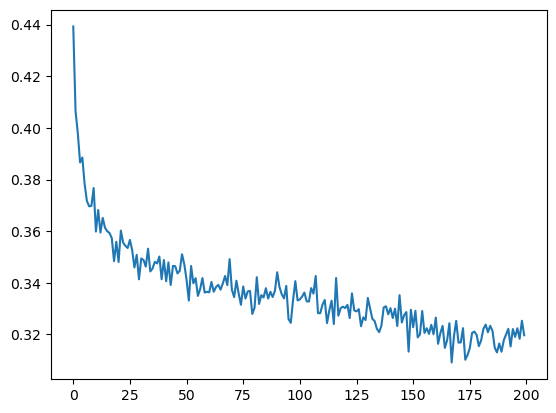

In [129]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [130]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.064134120941162
val 2.0910372734069824
